In [112]:
# Libraries

import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

In [40]:
# Load in data

file_path = "/Users/adammcmahan/Library/CloudStorage/OneDrive-Personal/Desktop/Bellevue/DSC630/Milestone Project/Data/reviews_data.csv"
df = pd.read_csv(file_path)

In [107]:
# Sentiment at full comment level

df['comment_compound'] = df['Review'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['comment_pos'] = df['Review'].apply(lambda x: analyzer.polarity_scores(str(x))['pos'])
df['comment_neu'] = df['Review'].apply(lambda x: analyzer.polarity_scores(str(x))['neu'])
df['comment_neg'] = df['Review'].apply(lambda x: analyzer.polarity_scores(str(x))['neg'])

# Optionally, label sentiment
def label_comment_sentiment(compound):
    if compound <= -0.35:
        return 'negative'
    elif compound >= 0.35:
        return 'positive'
    else:
        return 'neutral'

df['comment_sentiment_label'] = df['comment_compound'].apply(label_comment_sentiment)

In [109]:
# Split sentences

# Initialize custom sentence tokenizer
punkt_param = PunktParameters()
sentence_splitter = PunktSentenceTokenizer(punkt_param)

# Sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentence splitting + sentiment scoring
def analyze_sentences(review):
    review = str(review)  # Cast to string to avoid issues
    sentences = sentence_splitter.tokenize(review)
    return [{'sentence': s, 'score': analyzer.polarity_scores(s)} for s in sentences]

# Apply the function
df['sentence_analysis'] = df['Review'].apply(analyze_sentences)

# Expand into individual sentences with sentiment scores
df_sentences = df.explode('sentence_analysis').reset_index(drop=True)
df_sentences['sentence'] = df_sentences['sentence_analysis'].apply(lambda x: x['sentence'])
df_sentences['compound'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['compound'])
df_sentences['pos'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['pos'])
df_sentences['neu'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['neu'])
df_sentences['neg'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['neg'])

# Clean up
df_sentences.drop(columns=['sentence_analysis'], inplace=True)
print(df_sentences.head())

       name           location                     Date  Rating  \
0     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
1     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
2     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
3     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
4  Courtney         Apopka, FL   Reviewed July 16, 2023     5.0   

                                              Review    Image_Links  \
0  Amber and LaDonna at the Starbucks on Southwes...  ['No Images']   
1  Amber and LaDonna at the Starbucks on Southwes...  ['No Images']   
2  Amber and LaDonna at the Starbucks on Southwes...  ['No Images']   
3  Amber and LaDonna at the Starbucks on Southwes...  ['No Images']   
4  ** at the Starbucks by the fire station on 436...  ['No Images']   

   comment_compound  comment_pos  comment_neu  comment_neg  \
0            0.8991        0.191        0.809        0.000   
1            0.8991        0.191        0.809 

In [111]:
# Adding IDs

# Add a unique review ID before sentence splitting
df['review_id'] = df.index + 1  # Start IDs at 1 for clarity

# Apply sentence-level analysis
df['sentence_analysis'] = df['Review'].apply(analyze_sentences)

# Expand and organize the sentence-level DataFrame
df_sentences = df.explode('sentence_analysis').reset_index(drop=True)

# Add structured columns
df_sentences['review_id'] = df_sentences['review_id']  # Preserved from original
df_sentences['sentence'] = df_sentences['sentence_analysis'].apply(lambda x: x['sentence'])
df_sentences['compound'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['compound'])
df_sentences['pos'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['pos'])
df_sentences['neu'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['neu'])
df_sentences['neg'] = df_sentences['sentence_analysis'].apply(lambda x: x['score']['neg'])

# Add global sentence ID
df_sentences['sentence_id'] = range(1, len(df_sentences) + 1)

# Drop nested column
df_sentences.drop(columns=['sentence_analysis'], inplace=True)

# Reorder columns for readability
df_sentences = df_sentences[['sentence_id', 'review_id', 'location', 'Date', 'Rating', 'sentence', 'compound', 'pos', 'neu', 'neg']]

In [113]:
#  Label compound

def label_sentiment(compound):
    if compound <= -0.35:
        return 'negative'
    elif compound >= 0.35:
        return 'positive'
    else:
        return 'neutral'

df_sentences['sentiment_label'] = df_sentences['compound'].apply(label_sentiment)

In [115]:
df_sentences.to_csv('/Users/adammcmahan/Desktop/reviews_data_sentence2.csv', index=False)

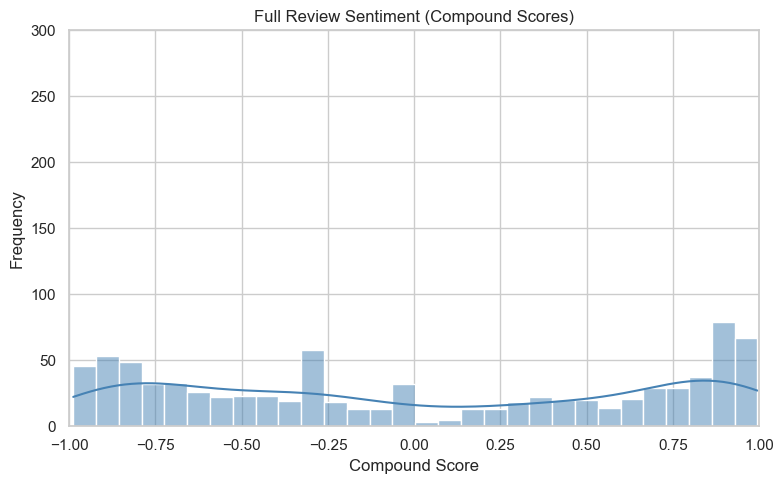

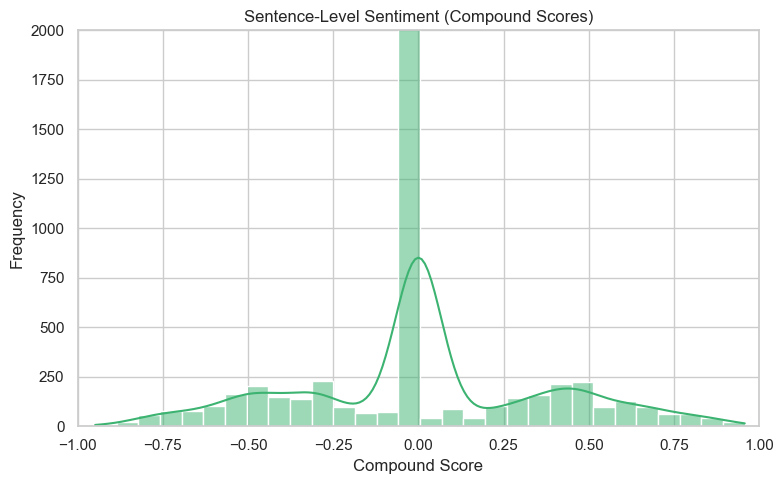

In [129]:
# Histograms

sns.set(style="whitegrid")

# Full
plt.figure(figsize=(8, 5))
sns.histplot(df['comment_compound'], bins=30, kde=True, color='steelblue')
plt.title('Full Review Sentiment (Compound Scores)')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.ylim(0, 300)  # Scaled for smaller dataset
plt.tight_layout()
plt.show()

# Sentence
plt.figure(figsize=(8, 5))
sns.histplot(df_sentences['compound'], bins=30, kde=True, color='mediumseagreen')
plt.title('Sentence-Level Sentiment (Compound Scores)')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.ylim(0, 2000)  # Scaled for ~5,000 rows
plt.tight_layout()
plt.show()

In [123]:
# Correlations

from scipy.stats import pearsonr
import numpy as np

# Full Review: drop NaNs/infs
df_clean = df[['comment_compound', 'Rating']].replace([np.inf, -np.inf], np.nan).dropna()

corr_full, p_full = pearsonr(df_clean['comment_compound'], df_clean['Rating'])
print(f"Full Review Sentiment vs. Rating")
print(f"Pearson Correlation: {corr_full:.3f}")
print(f"P-value: {p_full:.4f}")

# Sentence-Level: average per review
sentence_avg = df_sentences.groupby('review_id')['compound'].mean().reset_index()
sentence_avg.columns = ['review_id', 'avg_sentence_compound']

# Merge with rating
merged = df[['review_id', 'Rating']].merge(sentence_avg, on='review_id')
merged = merged.replace([np.inf, -np.inf], np.nan).dropna()

corr_sentence, p_sentence = pearsonr(merged['avg_sentence_compound'], merged['Rating'])
print(f"\nSentence-Level Sentiment vs. Rating")
print(f"Pearson Correlation: {corr_sentence:.3f}")
print(f"P-value: {p_sentence:.4f}")

Full Review Sentiment vs. Rating
Pearson Correlation: 0.440
P-value: 0.0000

Sentence-Level Sentiment vs. Rating
Pearson Correlation: 0.563
P-value: 0.0000


In [76]:
# Upload file with handcode

file_path_hc = "/Users/adammcmahan/Library/CloudStorage/OneDrive-Personal/Desktop/Bellevue/DSC630/Milestone Project/Data/reviews_data_sentence_hc.csv"
df_hc = pd.read_csv(file_path_hc)

df_hc.head()

,sentence_id,review_id,location,Date,Rating,sentence,compound,pos,neu,neg,sentiment_label,handcode
0,1,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,0.6863,0.303,0.697,0.000,positive,positive
1,2,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,There is always a smile in their voice when th...,0.5859,0.270,0.730,0.000,positive,positive
2,3,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,"And their customer service is always spot-on, ...",0.3612,0.135,0.865,0.000,positive,positive
3,4,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,I would actually give them more than 5 stars i...,0.0000,0.000,1.000,0.000,neutral,positive
4,5,2,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,0.4728,0.118,0.818,0.063,positive,positive


In [80]:
# Map sentiment strings to numeric values
sentiment_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

# Create new column
df_hc['handcode_numeric'] = df_hc['handcode'].map(sentiment_map)

In [82]:
df_hc['handcode'].notna().sum()

341

,sentence_id,review_id,location,Date,Rating,sentence,compound,pos,neu,neg,sentiment_label,handcode,handcode_numeric
0,1,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,0.6863,0.303,0.697,0.000,positive,positive,1.0
1,2,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,There is always a smile in their voice when th...,0.5859,0.270,0.730,0.000,positive,positive,1.0
2,3,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,"And their customer service is always spot-on, ...",0.3612,0.135,0.865,0.000,positive,positive,1.0
3,4,1,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,I would actually give them more than 5 stars i...,0.0000,0.000,1.000,0.000,neutral,positive,1.0
4,5,2,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,0.4728,0.118,0.818,0.063,positive,positive,1.0


In [94]:
comparison = df_hc.dropna(subset=['handcode_numeric', 'compound']).copy()

match_rate = (comparison['handcode_numeric'] == comparison['compound']).mean()
print(f"Numeric agreement between handcoded and VADER: {match_rate:.2%}")

Numeric agreement between handcoded and VADER: 20.23%


In [96]:
sentiment_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

df_hc['sentiment_label_numeric'] = df_hc['sentiment_label'].map(sentiment_map)
df_hc['handcode_numeric'] = df_hc['handcode'].map(sentiment_map)

In [100]:
comparison = df_hc.dropna(subset=['sentiment_label_numeric', 'handcode_numeric']).copy()

match_rate = (comparison['sentiment_label_numeric'] == comparison['handcode_numeric']).mean()
print(f"Agreement between sentiment_label and handcode: {match_rate:.2%}")

Agreement between sentiment_label and handcode: 62.76%


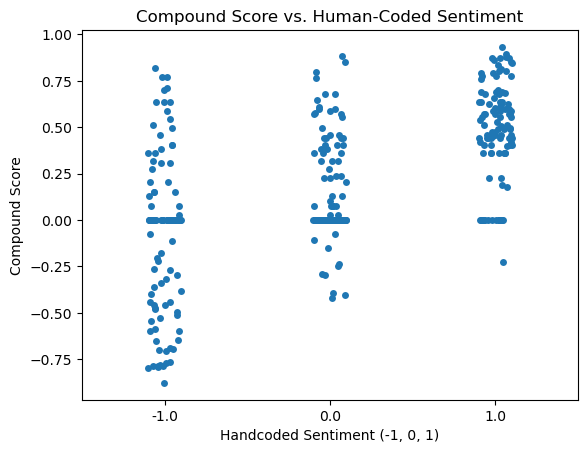

In [110]:
sns.stripplot(data=df_hc.dropna(subset=['handcode_numeric']), x='handcode_numeric', y='compound', jitter=True)
plt.title('Compound Score vs. Human-Coded Sentiment')
plt.xlabel('Handcoded Sentiment (-1, 0, 1)')
plt.ylabel('Compound Score')
plt.show()

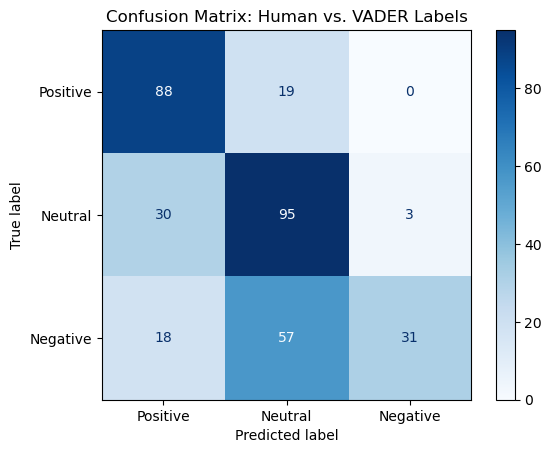

In [114]:
comparison = df_hc.dropna(subset=['handcode_numeric', 'sentiment_label_numeric'])
cm = confusion_matrix(comparison['handcode_numeric'], comparison['sentiment_label_numeric'], labels=[1, 0, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Human vs. VADER Labels')
plt.show()

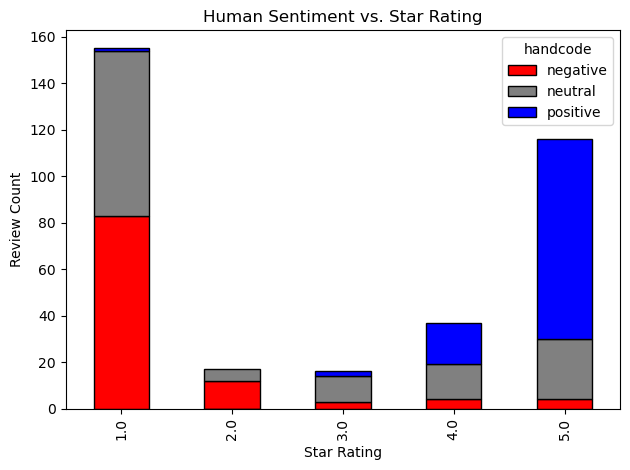

In [130]:

# Group and reformat data
sentiment_counts = df_hc.groupby(['Rating', 'handcode']).size().unstack(fill_value=0)

# Define custom colors
colors = {'positive': 'blue', 'neutral': 'gray', 'negative': 'red'}
color_order = [colors[label] for label in sentiment_counts.columns]

# Plot
sentiment_counts.plot(
    kind='bar',
    stacked=True,
    color=color_order,
    edgecolor='black'
)

plt.title('Human Sentiment vs. Star Rating')
plt.ylabel('Review Count')
plt.xlabel('Star Rating')
plt.tight_layout()
plt.show()